# Сборный проект №2

## Постановка задачи

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.  
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.  
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  
Вам нужно:
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Технологический процесс


Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.  

Опишем каждую стадию:  
1. Флотация:  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.  
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  
2. Очистка:  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных

Технологический процесс:  
`Rougher feed` — исходное сырье  
`Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
`Xanthate` — ксантогенат (промотер, или активатор флотации);  
`Sulphate` — сульфат (на данном производстве сульфид натрия);  
`Depressant` — депрессант (силикат натрия).  
`Rougher process` (англ. «грубый процесс») — флотация;  
`Rougher tails` — отвальные хвосты;  
`Float banks` — флотационная установка;  
`Cleaner process` — очистка;  
`Rougher Au` — черновой концентрат золота;  
`Final Au` — финальный концентрат золота.  

Параметры этапов  
`air amount` — объём воздуха;  
`fluid levels` — уровень жидкости;  
`feed size` — размер гранул сырья;  
`feed rate` — скорость подачи.

## План проекта

1. [Подготовка данных](#prep)  
    1.1. [Импорт данных, первичный осмотр](#import)  
    1.2. [Проверка расчета эффективности обогащения](#calc_check)  
    1.3. [Анализ признаков недоступных в тестовом датасете](#analysis_test)  
    1.4. [Проведение предобработки данных](#prep_data)  
2. [Исследовательский анализ данных](#analysis_data)  
    2.1. [Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#metal)  
    2.2. [Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#granule)  
    2.3. [Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.](#substance)  
3. [Построение модели](#model)  
    3.1. [Функция для вычисления итоговой sMAPE](#def_sMAPE)  
    3.2. [Обучите разные модели и оцените их качество кросс-валидацией.](#model)  
    3.3. [Выводы по построению моделей](#concl_3)  
4. [Общий вывод](#total_concl)  

## Подготовка данных <a id='prep'></a>

В следующей ячейке будут импортированы библиотеки для работы над проектом

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

### Импорт данных, первичный осмотр <a id='import'></a>

In [2]:
# функция пдля импорта данных
def import_df(data):
    try:
        df =  pd.read_csv('C:/Users/79153/Desktop/ya_projects/sborny_2/gold_recovery_'+
                          str(data)+'_new.csv')
    except:
        df = pd.read_csv('/datasets/gold_recovery_'+str(data)+'_new.csv')
    return df

# параметры импорта данных

set_names = ['train','test','full']           # исследумые датасеты

# автоматизированный импорт данных в словарь 

sets = {}     

for i in set_names:
    sets[(i)]= import_df(i)

Осмотрим содержимое датасетов

In [3]:
for i in sets:
    print(f'{i} dataset')
    display(sets[str(i)].info())
    print('---'*15)
    print("")

train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-

None

---------------------------------------------

test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.flo

None

---------------------------------------------

full dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tai

None

---------------------------------------------



In [4]:
for i in sets:
    print(f'{i} dataset')
    print("")
    display(sets[str(i)].head(5))
    print('---'*15)
    print("")

train dataset



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


---------------------------------------------

test dataset



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


---------------------------------------------

full dataset



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


---------------------------------------------



In [5]:
for i in sets:
    print(f'{i} dataset')
    print("")
    display(sets[str(i)].describe())
    print('---'*15)
    print("")

train dataset



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


---------------------------------------------

test dataset



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


---------------------------------------------

full dataset



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


---------------------------------------------



#### Вывод 
1. Данные не стандартизированы  
2. В данных присутствуют пропуски  
3. Имеет смысл провести индексацию по столбцу `date`  
Данные требуют проведения предобработки.  

### Проверка расчета эффективности обогащения <a id='calc_check'></a>

Проверим расчет эффективности обогащения по формуле из ТЗ. Саму проверку предлагается осуществить с помощью метрик *MAE* и *R2* из библиотеки *sklearn.metrics*

In [6]:
# исходные данные
C = sets['train']['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки;
F = sets['train']['rougher.input.feed_au']         # доля золота в сырье/концентрате до флотации/очистки;
T = sets['train']['rougher.output.tail_au']        # доля золота в отвальных хвостах после флотации/очистки.

# расчет эффективности с сохранением в дополнительный столбец
sets['train']['rougher.output.check'] = ((C*(F-T))/(F*(C-T)))*100

# вывод метрик
print('MAE: {:.4f}'.format(mean_absolute_error(sets['train']['rougher.output.recovery'], sets['train']['rougher.output.check'])))
print('R2: {:.4f}'.format(r2_score(sets['train']['rougher.output.recovery'], sets['train']['rougher.output.check'])))

# удаление лишнего столбца из датасета
sets['train'].drop('rougher.output.check', axis=1, inplace=True)

MAE: 0.0000
R2: 1.0000


Из метрик очевидно, что расчет проведен верно. Значение *R2 = 1* указывает на функциональную зависимость переменных - данные расчитаны по формулам.

### Анализ признаков недоступных в тестовом датасете <a id='analysis_test'></a>

In [7]:
list_columns = [i for i in sets['train'].columns if i not in sets['test'].columns]

In [8]:
display(list_columns)
print(f'Всего недоступных признаков: {len(list_columns)}')

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Всего недоступных признаков: 34


В датафрейме нехватает целевых признаков и ряда остальных признаков, которые должны нам говорить о результатах промежуточных процессов - хвоста, выходы со ступеней очисток 1-2, расчетные параметры. Вероятно процесс происходит достаточно быстро, что не позволяет получить таковые данные в процессе работы, так же предположу что заказчик хочет знать результат исходя из исходного сырья. Данный датасет придется дополнить целевыми признаками, а остальные убрать из тренировочной сборки для корректности подсчета.

### Проведение предобработки данных <a id='prep_data'></a>

Приведем столбец `data` в формат врмени с последующей индексацией по нему датафремов

In [9]:
for set in sets:
    sets[str(set)]['date'] = pd.to_datetime(sets[str(set)]['date'], format='%Y-%m-%d %H:%M:%S')
    sets[str(set)].set_index(keys='date', inplace=True)

Определим целевые и не целевые признаки

In [10]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [i for i in sets['full'].columns if i not in ['rougher.output.recovery', 'final.output.recovery']]

Поскольку мы имеем дело с процессом распределеным во времени логично предположить что ему свойственна некоторая иннертность - данные отсутвующие за определенный час находятся в промежутке между последующим часом и предыдущим. Поэтому для заполнения пропусков выберем метод линейной интерполяции

In [11]:
features_for_test = [i for i in sets['test'].columns if i not in ['rougher.output.recovery', 'final.output.recovery']]

for set in sets:
    if set == 'test':
        sets[str(set)][features_for_test].interpolate(method = 'linear',inplace=True, axis = 1)
    else:
        sets[str(set)].interpolate(method = 'linear',inplace=True, axis = 1)

Добавим целевые признаки из общего датафрейма в тестовый

In [12]:
sets['test'] = sets['test'].join(sets['full'][targets], how='left')

Пропуски в целевых признаках восстановить не удастся, поэтому удалим их. Так же дочистим то что осталось после заполнения методом линейной интерполяции в нецелевых признаках и присоединения целей

In [13]:
for set in sets:
    sets[str(set)].dropna(subset=targets, how='any', axis=0, inplace=True)
    if set == 'test':
        sets[str(set)].dropna(subset=features_for_test, how='any', axis=0, inplace=True)
    else:
        sets[str(set)].dropna(subset=features, how='any', axis=0, inplace=True)

Проверим датасеты на дубликаты

In [14]:
for i in sets:
    print(f'{i} dataset')
    print(f'Число явных дубликатов в датафрейме: {sets[str(i)].duplicated().sum()}')
    print('---'*15)
    print("")

train dataset
Число явных дубликатов в датафрейме: 0
---------------------------------------------

test dataset
Число явных дубликатов в датафрейме: 0
---------------------------------------------

full dataset
Число явных дубликатов в датафрейме: 0
---------------------------------------------



Датасеты распределены по времени производство на конвейре, осмотрим детальнее что представляет из себя временной ряд

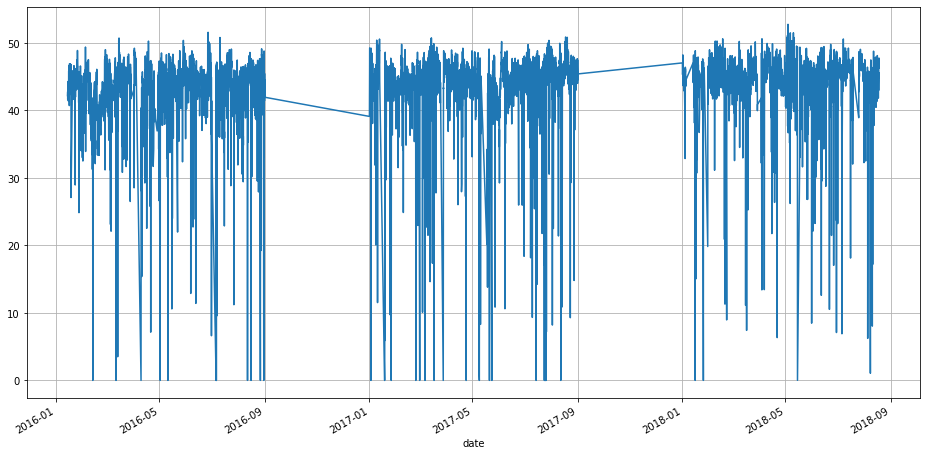

In [15]:
sets['train']['final.output.concentrate_au'].plot(kind='line', figsize=(16,8), grid=True)
plt.show()

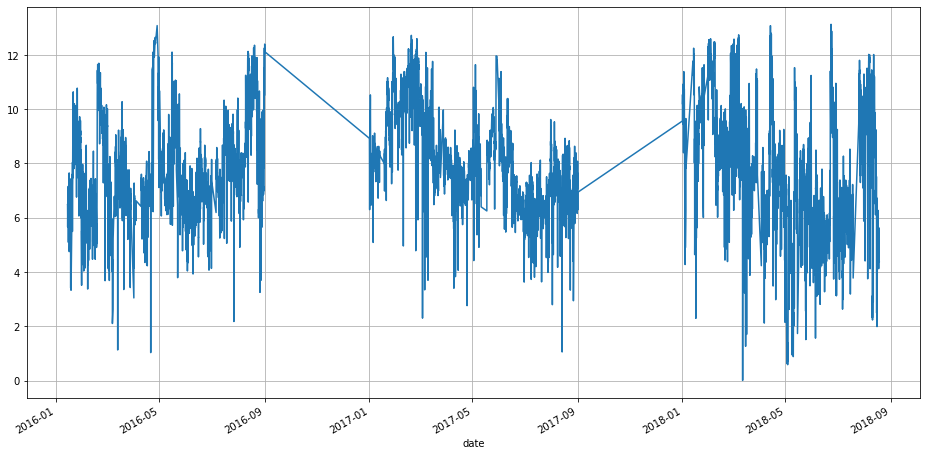

In [16]:
sets['train']['rougher.input.feed_au'].plot(kind='line', figsize=(16,8), grid=True)
plt.show()

#### Вывод
1. Пропуски в датасетах обработаны
2. Проведена индексация по столбцу `date`
3. Проведена проверка на дубликаты
4. Проведена проверка расчета эфективности обогащения руды
5. Временной ряд неполный
6. Есть нулевые значения концентрации золота, вероятнее всего это остановы и пуски производства, так как на финальной стадии такого количества нулей нет, так же возможно просто незаписанные значения, их обработаем в следующем этапе.

Предобработка данных завершена. Стандартизация данных будет проведена после исследовательского анализа данных.

### Исследовательский анализ данных <a id='analysis_data'></a>

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки <a id='metal'></a>

In [17]:
metals = ['au', 'ag', 'pb']
stages = ['rougher.input.feed','rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

# извлечем датафрейм для построения графиков
cols = []
for metal in metals:
    for stage in stages:
        cols.append(stage+'_'+metal)
data_for_plot = sets['train'][cols].mean()
for stage in stages:
    data_for_plot[stage+'_'+'other'] = 100
    for metal in metals:
        data_for_plot[stage+'_'+'other'] -= data_for_plot[stage+'_'+metal]
data_for_plot.sort_index(inplace=True)
data_for_plot

final.output.concentrate_ag                  5.142034
final.output.concentrate_au                 44.004851
final.output.concentrate_other              40.720156
final.output.concentrate_pb                 10.132960
primary_cleaner.output.concentrate_ag        8.201019
primary_cleaner.output.concentrate_au       32.386304
primary_cleaner.output.concentrate_other    49.791858
primary_cleaner.output.concentrate_pb        9.620819
rougher.input.feed_ag                        8.579409
rougher.input.feed_au                        7.866651
rougher.input.feed_other                    78.129472
rougher.input.feed_pb                        5.424469
rougher.output.concentrate_ag               11.776051
rougher.output.concentrate_au               19.440279
rougher.output.concentrate_other            61.118841
rougher.output.concentrate_pb                7.664829
dtype: float64

Численно значения определены, добавим немного визуализации

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


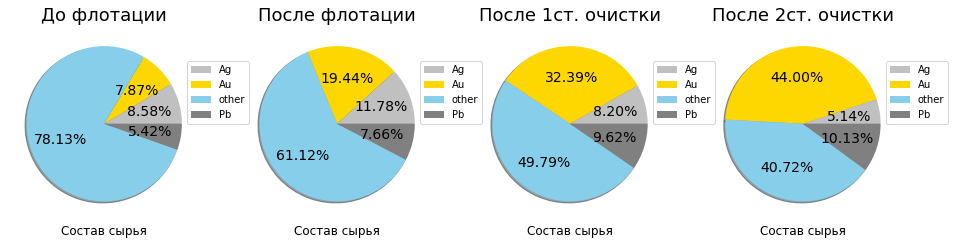

In [18]:
concentrations = [data_for_plot[8:12], data_for_plot[12:16], data_for_plot[4:8], data_for_plot[0:4]]
titles = ['До флотации','После флотации','После 1ст. очистки', 'После 2ст. очистки']
colors = ['silver','gold', 'skyblue', 'gray']

rows = 1
cols = 4
counter = 1

for metals in concentrations:
    fig = plt.subplot(rows, cols, counter)
    ax =  metals.plot(kind='pie', figsize=(16,12), fontsize=14, labels=None,
                   shadow=True, autopct='%1.2f%%', colors = colors, title=titles[counter-1])
    plt.legend(fontsize=16)
    ax.title.set_size(18)
    ax.legend(['Ag', 'Au', 'other', 'Pb'], bbox_to_anchor=(0.9,0.85), fontsize=10)
    plt.xlabel('Состав сырья', fontsize=12)
    plt.ylabel('')
    counter += 1
plt.show()
 

#### Вывод
Технологический процесс идет нормально - доля золота в сырье растет с каждой ступенью очистки, а доля остальных металлов снижается. Концентрация серебра падает, так как основной смысл процесса - добыча золота. Доля свинца несколько растет - предположу, что технологическим процессом не предусмотрено удаление свинца и это происходит при последующей очистке руды.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках <a id='granule'></a>

Для данного исследования важно сравнить размеры гранул сырья, так как в случае сильного расхождения будет невозможно использовать предложенное разбиение на выборки.

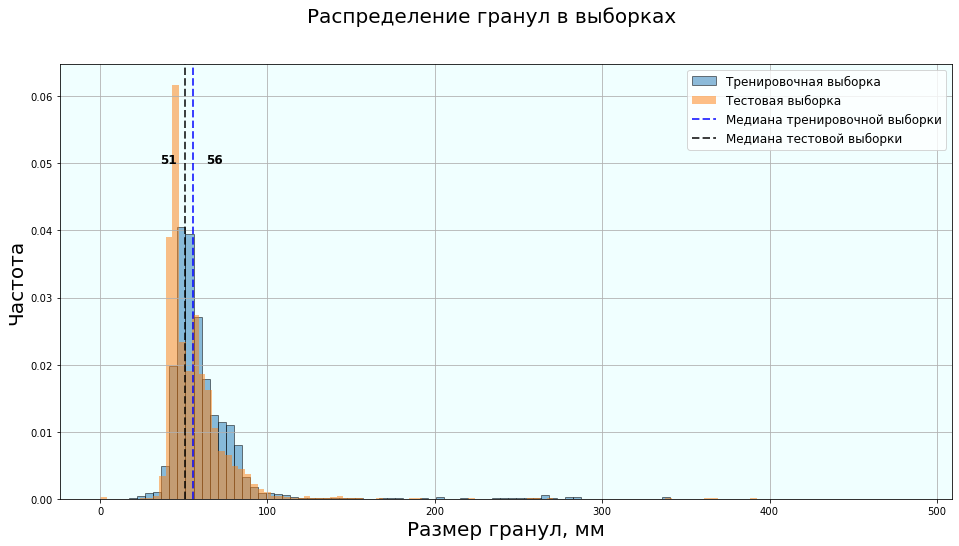

In [19]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Распределение гранул в выборках',  fontsize=20)

# чертим гистограммы
plt.xlabel('Размер гранул, мм', fontsize=20)
plt.ylabel('Частота', fontsize=20)
ax_1 = sets['train']['rougher.input.feed_size'].hist(bins=100, density=True, alpha=0.5, label='Тренировочная выборка',ec='black')
ax_2 = sets['test']['rougher.input.feed_size'].hist(bins=100, density=True, alpha=0.5, label='Тестовая выборка')
ax_1.patch.set_facecolor('#F0FFFF')
plt.legend(loc='upper right', fontsize=15)

# начертим медианы
med_train = sets['train']['rougher.input.feed_size'].median()
med_test = sets['test']['rougher.input.feed_size'].median()

plt.axvline(x=med_train,linewidth=2, color='blue', linestyle='--', alpha=0.75)
ax_1.text(med_train+8, 0.05, '{0:.0f}'.format(med_train), 
            fontweight='bold', fontsize='large')
plt.axvline(x=med_test,linewidth=2, color='black', linestyle='--', alpha=0.75)
ax_2.text(med_test-15, 0.05, '{0:.0f}'.format(med_test), 
            fontweight='bold', fontsize='large')
plt.legend(['Тренировочная выборка', 'Тестовая выборка',
            'Медиана тренировочной выборки', 'Медиана тестовой выборки'], prop={'size':12})
plt.show()

#### Вывод

Распределение гранул в тестовой и тренировочной выборках отличается - в тренировочную выборку попали гранулы чуть крупнее (медиана - 56), чем в тренировочную выборку (51). Но сама структура датасета сохраняется - скос, распределение. Данное различие не следует считать существенным, но имеет смысл держать его ввиду.

### Исследование суммарной концентрации всех веществ на разных стадиях. <a id='substance'></a>

В тестовом датасете отсутствуют концентрации веществ, данный этап будет выполнен только на тренировочном и полном датасетах. Данный этап производится для того, чтобы отсеять выбросы по всем концентрациям веществ. 

In [20]:
for df in sets['train'], sets['full']:
    for stage in stages:
        df[(stage + '_sum_concentration')] = (df[stage + '_au'] + df[stage + '_ag'] + df[stage + '_pb'] + df[stage + '_sol'])

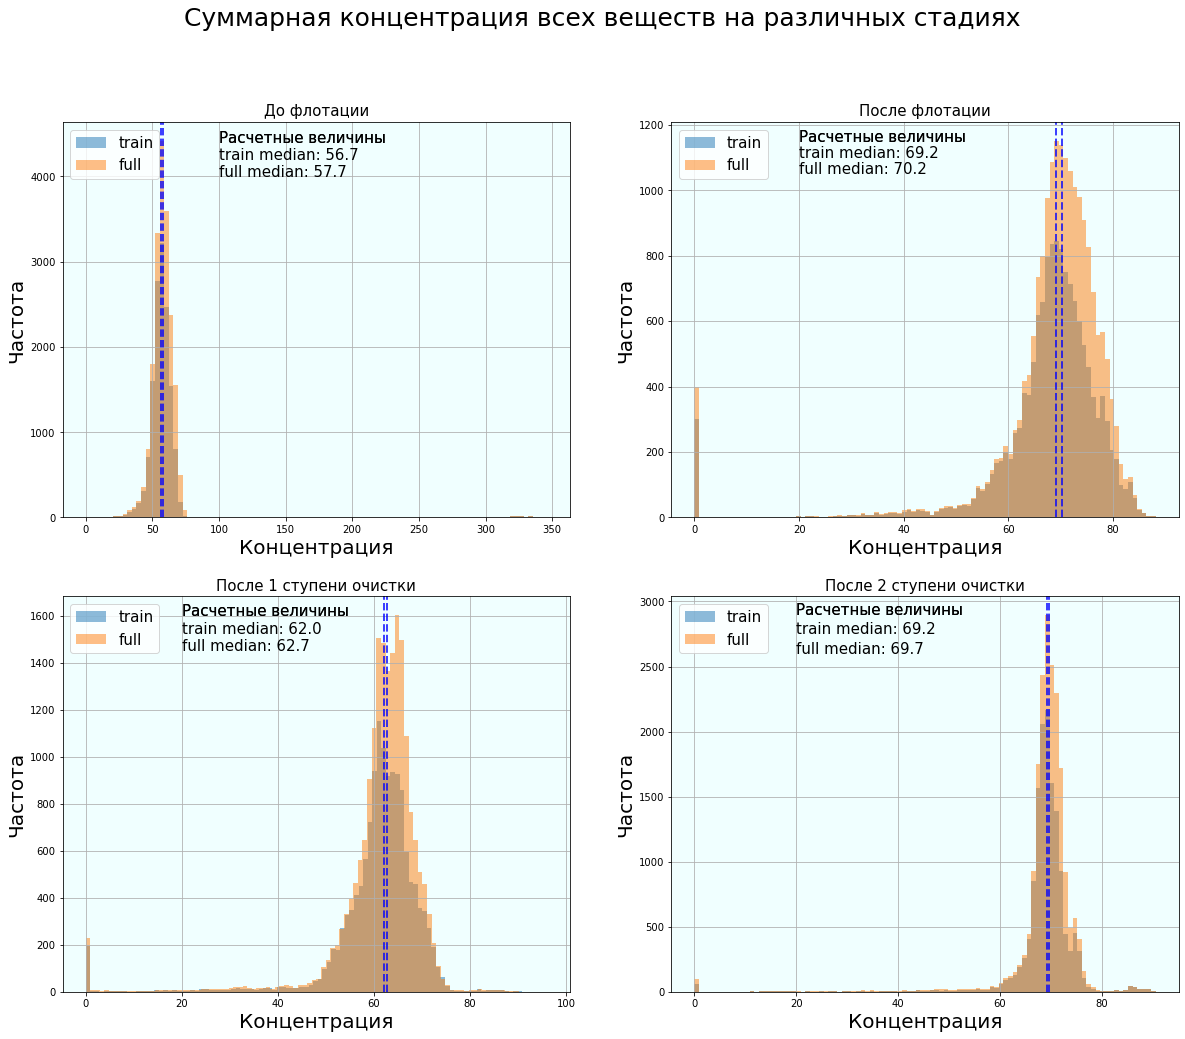

In [21]:
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Cуммарная концентрация всех веществ на различных стадиях',  fontsize=25)

label = ['train', 'full']
titles = ['', 'До флотации', 'После флотации', 'После 1 ступени очистки', 'После 2 ступени очистки']
rows = 2
cols = 2
counter = 1
for stage in stages:
    ax = plt.subplot(rows, cols, counter)
    plt.xlabel('Концентрация', fontsize=20)
    plt.ylabel('Частота', fontsize=20)
    
    # координаты текста
    x_text=['',100, 20, 20, 20]
    y_text=['',4400, 1150, 1600, 2900]
    text_shift=['',-200, -50, -75, -150]
    
    label_counter = 0
    for df in sets['train'], sets['full']:
        # рисуем гистограммы
        ax = df[stage + '_sum_concentration'].hist(bins=100, alpha=0.5, label=label[label_counter])
        ax.set_title(titles[counter], fontsize=15)
        
        # чертим медианы
        med = df[stage + '_sum_concentration'].median()
        plt.axvline(x=med ,linewidth=2, color='blue', linestyle='--', alpha=0.75)
        
        # вывод расчетных величин
        ax.text(x_text[counter], y_text[counter], 'Расчетные величины', fontsize=15)
        ax.text(x_text[counter], y_text[counter]+text_shift[counter]+(text_shift[counter])**label_counter,str(label[label_counter])+' median: '+str(round(med,1)), fontsize=15)
        ax.patch.set_facecolor('#F0FFFF')
        label_counter +=1
    plt.legend(loc='upper left', fontsize=15)
    counter += 1
plt.show()

Очевидно наличие выбросов в районе 0, определим доверительные интервалы для каждой стадии

In [22]:
def get_intervals(data, stage):
    q1 = data[stage + '_sum_concentration'].quantile(0.25)
    q3 = data[stage + '_sum_concentration'].quantile(0.75)
    diff = q3 - q1
    k = 1.5
    
    left_int = np.round(np.where( (q1 - k * diff) > 0, q1 - k * diff, 0),2)
    right_int = np.round(np.where( (q3 + k * diff) > 0, q3 + k * diff, 0),2)
   
    print('Границы доверительного интервала для {} : {} - {}'.format(stage+'_sum_concentration', left_int, right_int))
    
    return (left_int, right_int)

In [23]:
intervals = []
for i in range(4):
    intervals.append(get_intervals(sets['train'], stages[i]))

Границы доверительного интервала для rougher.input.feed_sum_concentration : 40.33 - 73.28
Границы доверительного интервала для rougher.output.concentrate_sum_concentration : 52.11 - 86.22
Границы доверительного интервала для primary_cleaner.output.concentrate_sum_concentration : 47.75 - 76.22
Границы доверительного интервала для final.output.concentrate_sum_concentration : 62.55 - 76.24


#### Вывод

Медианные значения по датасетам практически не различаются. Частотность медианого значения концентрации растет с каждым этапом. При этом после 1 ступени очистки сама медиана снизилась - видимо целевые вещества подвергаются грубой очистке и с большой долей шлака уходит и часть целевых веществ.  
В датасетах присутствуют выбросы в районе 0, которые с очисткой уменьшаются - вероятно это запуски или остановы производственного процесса. От этих выбросов предлагается избавиться ограничив данные по доверительному интервалу, а так же в процессе стандартизации применив *RobustScaler*, в отличие от *StandardScaler* при масштабировании *RobustScaler* вычитает из данных медиану и делит результат на интерквартильный размах (75% квантиль - 25% квантиль). Таким образом мы должны снизить влияние выбросов. 

In [24]:
for i in range(len(stages)):
    sets['train'].drop((sets['train'][
        (sets['train'][stages[i]+'_sum_concentration']) < intervals[i][0]]).index, inplace=True)
    sets['train'].drop((sets['train'][
        (sets['train'][stages[i]+'_sum_concentration']) > intervals[i][1]]).index, inplace=True)

### Построение модели <a id='model'></a>

Заказчик посчитал что часть колонок не нужна в тестовом датасете, поэтому удалим "лишние", в том числе созданные в процессе исследования, чтобы модель тестировалась корректно

In [25]:
list_columns_to_drop = [i for i in sets['train'].columns if i not in sets['test'].columns]
sets['train'].drop(list_columns_to_drop, axis=1, inplace=True)

Заново определим *targets* и *features* с учетом, что нам предлагается предсказать две величины - эффективность обогащения чернового концентрата `rougher.output.recovery` и эффективность обогащения финального концентрата `final.output.recovery`.  
Не все признаки являются определяющими для `rougher.output.recovery`, так как на процесс флотации очевидно не влиют все последующие процессы.  
Для определения `final.output.recovery` можно как выбрать данные со всего датасета, так и отсечь выходные данные 2 ступени очистки. Но так как тестовый датасет не содержит данных по выходу из 1-2 ступени очистки, а только параметры процессов, придется взять все доступные данные.  

In [26]:
# признаки для модели 1 уровня
cols_features_rougher = sets['train'].filter(regex="rougher.").columns
features_train_rougher = sets['train'] [cols_features_rougher].drop(['rougher.output.recovery'], axis=1)
features_test_rougher = sets['test'] [cols_features_rougher].drop(['rougher.output.recovery'], axis=1)

# признаки для модели 2 уровня
features_train_final = sets['train'].drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test_final = sets['test'].drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

# целевые признаки 
target_train_rougher = pd.Series(sets['train']['rougher.output.recovery'])
target_train_final = pd.Series(sets['train']['final.output.recovery'])

target_test_rougher = pd.Series(sets['test']['rougher.output.recovery'])
target_test_final = pd.Series(sets['test']['final.output.recovery'])

### Функция для вычисления итоговой sMAPE <a id='def_sMAPE'></a>

Запишем заданные условием метрики

In [27]:
def sMAPE(y_target,y_pred):
    error = np.mean(abs(y_target - y_pred)/((abs(y_target)+abs(y_pred))/2))*100
    return error
def sMAPE_total(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

### Обучите разные модели и оцените их качество кросс-валидацией <a id='model'></a>

Используем три модели *LinearRegression()*, *Ridge()* и *Lasso()*. Так же сравним их с результатами работы *DummyRegressor()*, выполнив таким образом проверку на вменяемость.\
Для этого объявим ряд вспомогательных функций:

In [28]:
def initial_model(model, parameters, regressor):

    # пайплайн
    pipe = Pipeline([('normalizer', RobustScaler()), (regressor, model)])
    
    # ввод метрики
    smape_scorer = make_scorer(sMAPE, greater_is_better=False)
  
    grid_search_cv = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=smape_scorer, cv=5)
    return grid_search_cv

In [29]:
# функция для флотации

def result_model_rougher(model):
    # обучение и предсказание
    model.fit(features_train_rougher,target_train_rougher)
    predicted = model.predict(features_test_rougher)
    # расчет метрики
    score = sMAPE(target_test_rougher, predicted)
    return score

# функция для финальной стадии очистки

def result_model_final(model):
    # обучение и предсказание
    model.fit(features_train_final,target_train_final)
    predicted = model.predict(features_test_final)
    # расчет метрики
    score = sMAPE(target_test_final, predicted)
    return score

# сбор результатов
scores = pd.DataFrame()

def total_results(model, name):
    score = scores.append({'model' : name,
                   'sMAPE_rougher' : result_model_rougher(model),
                   'sMAPE_final' : result_model_final(model),
                   'sMAPE_total' : sMAPE_total(result_model_rougher(model), result_model_final(model))}, ignore_index = True)
    return score

In [30]:
Linear_Regression = initial_model(model=LinearRegression(),
                   parameters={'linear__fit_intercept': [True, False],
                               'linear__copy_X': [True, False]},
                   regressor='linear')

scores = total_results(Linear_Regression, 'Linear_Regression')

In [31]:
Ridge_model = initial_model(model=Ridge(max_iter=2000),
                   parameters= {'ridge__alpha': range(75,100),
                                'ridge__fit_intercept': [True, False],
                                'ridge__copy_X': [True, False]},
                   regressor='ridge')

scores = total_results(Ridge_model, 'Ridge')

In [32]:
Lasso_model = initial_model(model=Lasso(max_iter=2000),
                   parameters= {'lasso__alpha': range(0,20),
                                'lasso__fit_intercept': [True, False],
                                'lasso__copy_X': [True, False]},
                   regressor='lasso')

scores = total_results(Lasso_model, 'Lasso')

In [33]:
Dummy_Regressor = DummyRegressor(strategy="median")
scores = total_results(Dummy_Regressor, 'Dummy_Regressor')

#### Подсчет итогового значения отклонения.

Осмотрим результаты обучения моделей:

In [34]:
scores.set_index('model', drop=True, inplace=True)
scores

,sMAPE_rougher,sMAPE_final,sMAPE_total
model,,,
Linear_Regression,8.140923,8.772024,8.614249
Ridge,8.038510,8.733425,8.559696
Lasso,8.013908,8.248960,8.190197
Dummy_Regressor,8.277103,9.100367,8.894551


Лучшие результаты в данном случае показала модель Lasso, при этом все модели прошли проверку на вменяемость:

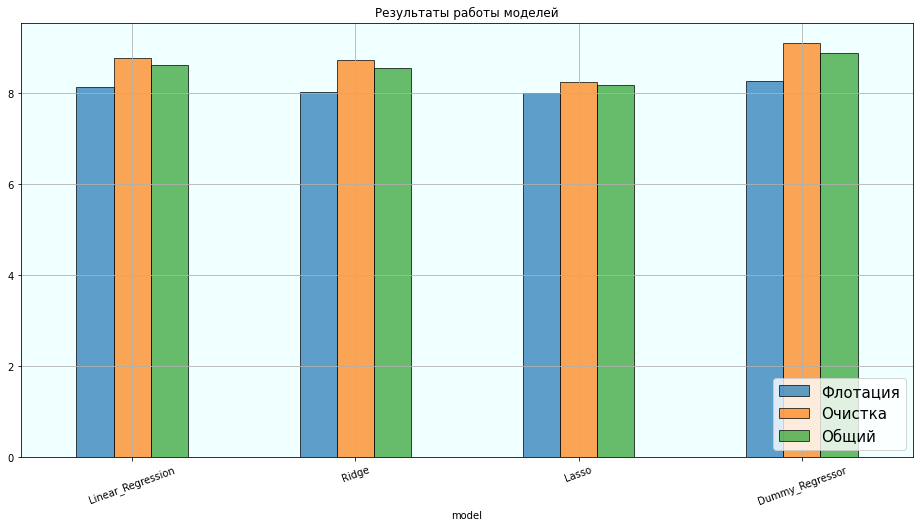

In [35]:
ax = scores.plot(kind='bar', ec='black', rot=20, figsize=(16,8), alpha=0.70, title='Результаты работы моделей', grid=True)
plt.legend(['Флотация', 'Очистка', 'Общий'],  loc='lower right', fontsize=15)
ax.set_facecolor('#F0FFFF')
plt.show()

Лучшие результаты в данном случае показала модель Lasso, при этом все модели прошли проверку на вменяемость. 
Проверим можно ли достичь лучшего результата объединив различные модели на разных этапах:

In [36]:
if sMAPE_total(scores['sMAPE_rougher'].min(), scores['sMAPE_final'].min()) < scores['sMAPE_total'].min():
    print('Объединение моделей дает положительный результат: {:.4f} против {:.4f}'
          .format(sMAPE_total(scores['sMAPE_rougher'].min(), scores['sMAPE_final'].min()), scores['sMAPE_total'].min()))
else:
    print('Объединение моделей не дает положительного результата, лучший результат: {:.4f}'.format(scores['sMAPE_total'].min()))
          

Объединение моделей не дает положительного результата, лучший результат: 8.1902


### Выводы по построению моделей <a id='concl_3'></a>

Все модели прошли проверку на вменяемость, получен адекватный результат. Следует учитывать специфику метрики - в формуле итогового отклонения коэффициент 0.25 не позволяет оказать первому этапу существенный внос погрешности в исследование, в то время как погрешность на этапе очистки влияет существеннее с коэффициентом 0.75 - финальный результат стремится к наихудшему результату из этапов, но основную погрешность вносит этап очистки.

### Общий вывод <a id='total_concl'></a>

В работе была проведена предобработка данных:
1. Проведена индексация по времени;
2. В данных были пропуски, заполнены линейной интерполяцией, так как датасет это процесс распределенный во времени;
3. Выбросы были удалены с использованием доверительных интервалов, а так же использован *RobustScaler*.
4. Проверен расчет эффективности обогащения - расчет верен.

При анализе данных было выявлено:
1. Доля золота растет с каждым этапом очистки;
2. Распределение концентраций и размера гранул в датасетах можно считать нормальным.

Построены три модели для предсказания эффективности процесса, а так же проведена проверка на вменяемость этих моделей. Лучший результат показала модель на основе *Lasso* - *sMAPE_total=8.1902*. Следует учитывать специфику метрики - в формуле итогового отклонения коэффициент 0.25 не позволяет оказать первому этапу существенный внос погрешности в исследование, в то время как погрешность на этапе очистки влияет существеннее с коэффициентом 0.75 - финальный результат стремится к наихудшему результату из этапов, но основную погрешность вносит этап очистки.